### Package

In [1]:
# Load package
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=2) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image

### Data Cleaning and EDA

In [3]:
# Data
df = pd.read_pickle("../input/wm811k-wafer-map/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


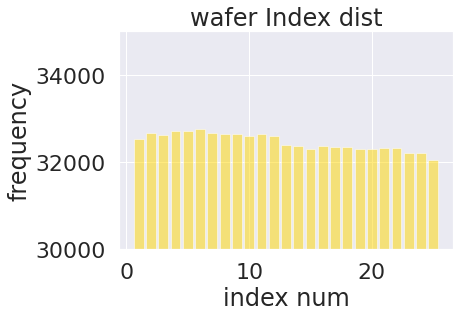

In [6]:
# 1. The distribution of lot_idx and num_wafer
lot_index = np.unique(df.waferIndex, return_counts=True)
plt.bar(lot_index[0], lot_index[1], color='gold', align='center', alpha=0.5)
plt.title("wafer Index dist")
plt.xlabel("index num")
plt.ylabel("frequency")
plt.ylim(30000, 34000)
plt.show()

In [7]:
# Drop column
df = df.drop(['waferIndex'], axis = 1)
df.info()

In [9]:
# 2. Add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']= df['waferMap'].apply(lambda x: find_dim(x))
df.head(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
477926,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29544,[],[],"(49, 39)"
510,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot21,[[Training]],[[none]],"(26, 26)"
730736,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",741.0,lot44264,[[Test]],[[none]],"(33, 29)"
702037,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43106,[[Training]],[[none]],"(25, 27)"
244393,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",22372.0,lot15319,[],[],"(153, 187)"


In [10]:
# 3. To check failureType distribution and encoding label
df['failureNum'] = df['failureType']
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df = df.replace({'failureNum':mapping_type})

/opt/conda/lib/python3.7/site-packages/pandas/core/array_algos/replace.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [11]:
# df_withlabel : labeled wafer
# df_withpattern : labeled & patterned wafer 
# df_nonpatter : labeled but non-patterned wafer
df_withlabel = df[(df['failureType']!=0)]
df_withlabel =df_withlabel.reset_index() #labeled index.
df_withpattern = df_withlabel[(df_withlabel['failureType'] != 'none')]
df_withpattern = df_withpattern.reset_index() #patterned index.
df_nonpattern = df_withlabel[(df_withlabel['failureType'] == 'none')] #nonpatterned index
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


(172950, 25519, 147431)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


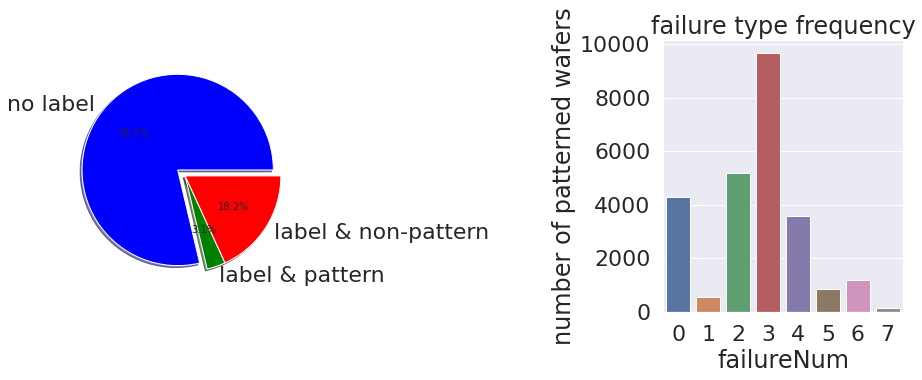

In [12]:
fig,ax = plt.subplots(1,2, figsize = (15,5))
colors = ['blue', 'green', 'red']
num_wafers=[len(df['waferMap'])-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]
labels = ['no label', 'label & pattern', 'label & non-pattern']
ax[0].pie(num_wafers, explode=(0.1,0,0), labels = labels, colors = colors, autopct = '%1.1f%%', shadow=True)
sns.countplot('failureNum', data=df_withpattern, ax=ax[1])
ax[1].set_title("failure type frequency")
ax[1].set_ylabel("number of patterned wafers")
plt.subplots_adjust(wspace = 1.5)
plt.show()

In [13]:
df_withlabel['waferMapDim'].value_counts()

(25, 27)      18781
(26, 26)      14366
(30, 34)      12400
(29, 26)      11751
(27, 25)      10682
              ...  
(41, 39)          1
(122, 104)        1
(54, 54)          1
(109, 111)        1
(43, 133)         1
Name: waferMapDim, Length: 346, dtype: int64

### Choose a subset of data
We choose the data with labels among two most popular group dim (25,27) & (26,26)

In [17]:
# Extract (25,27) & (26,26) waferMapDim data
def subwafer(sw,label):
    Dim0 = np.size(sw, axis=1)
    Dim1 = np.size(sw, axis=2)
    sub_df = df_withlabel.loc[df_withlabel['waferMapDim'] == (Dim0, Dim1)]
    sub_wafer = sub_df['waferMap'].values
    sw = sw.to(torch.device('cuda'))
    for i in range(len(sub_df)):
        waferMap = torch.from_numpy(sub_df.iloc[i,:]['waferMap'].reshape(1, Dim0, Dim1))
        waferMap = waferMap.to(torch.device('cuda'))
        sw = torch.cat([sw, waferMap])
        label.append(sub_df.iloc[i,:]['failureType'][0][0])
    x = sw[1:]
    y = np.array(label).reshape((-1,1))
    del waferMap, sw
    return x, y

sw0 = torch.ones((1, 25, 27))
sw1 = torch.ones((1, 26, 26))
label0 = list()
label1 = list()
x0, y0 = subwafer(sw0, label0)
x1, y1 = subwafer(sw1, label1)
x0.shape, x1.shape

(torch.Size([18781, 25, 27]), torch.Size([14366, 26, 26]))

### One-Hot encoding for image

In [18]:
# Add RGB space for one-hot encoding
# 0: non wafer -> R, 1: normal die -> G, 2: defect die -> B

def rgb_sw(x):
    Dim0 = np.size(x, axis=1)
    Dim1 = np.size(x, axis=2)
    new_x = np.zeros((len(x), Dim0, Dim1, 3))
    x = torch.unsqueeze(x,-1)
    x = x.to(torch.device('cpu'))
    x = x.numpy()
    for w in range(len(x)): 
        for i in range(Dim0):
            for j in range(Dim1):
                new_x[w, i, j, int(x[w, i, j])] = 1
    return new_x

rgb_x0 = rgb_sw(x0)
rgb_x1 = rgb_sw(x1)

### Reshape data

In [21]:
#To use two dim, we have to resize these data.
def resize(x):
    rwm = torch.ones((1,56,56,3))
    for i in range(len(x)):
        rwm = rwm.to(torch.device('cuda'))
        a = Image.fromarray(x[i].astype('uint8')).resize((56,56))
        a = np.array(a).reshape((1,56,56,3))
        a = torch.from_numpy(a)
        a = a.to(torch.device('cuda'))
        rwm = torch.cat([rwm, a])
    x = rwm[1:]
    del rwm
    return x

resized_x0 = resize(rgb_x0)
resized_x1 = resize(rgb_x1)

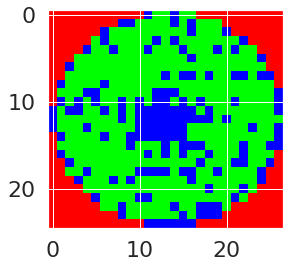

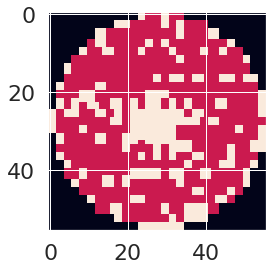

In [23]:
plt.imshow(rgb_x0[1000])
plt.show()
plt.imshow(torch.argmax(resized_x0[1000],axis=2).cpu().numpy())
plt.show()

In [24]:
# Concatenate all data together
resized_wm = torch.cat([resized_x0, resized_x1])
label_wm = np.concatenate((y0, y1))

### Convolutional Autoencoder

In [25]:
# parameters
args = {'BATCH_SIZE': 16,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 10
        }

In [26]:
# dataloader for autoencoder
resized_wm = resized_wm.permute(0,3,1,2)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
train_loader  = torch.utils.data.DataLoader(resized_wm, args['BATCH_SIZE'], shuffle=True)
resized_wm.shape, label_wm.shape

In [27]:
# delete data
del y0,y1,resized_x0, resized_x1
del rgb_x0, rgb_x1
del x0, x1

In [28]:
# AutoEncoder Model

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2,2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                                             nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                                             nn.Sigmoid())
            
    def encoder(self, x):
        encode = self.cnn_layer1(x)
        encode = self.cnn_layer2(encode)   
        return encode
    
    def decoder(self, x):
        decode = self.tran_cnn_layer1(x)
        decode = self.tran_cnn_layer2(decode)
        return decode

    def forward(self, x):
        output = self.encoder(x)
        output = self.decoder(output)
        return output

In [33]:
# Setup Model, loss_func, optimizer
model = ConvAutoEncoder().to(DEVICE)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)


In [34]:
!pip install ../input/torchsummary/torchsummary-1.5.1-py3-none-any.whl

Processing /kaggle/input/torchsummary/torchsummary-1.5.1-py3-none-any.whl


In [35]:
from torchsummary import summary
summary(model,(3,54,54), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 54, 54]             448
              ReLU-2           [16, 16, 54, 54]               0
         MaxPool2d-3           [16, 16, 27, 27]               0
            Conv2d-4           [16, 32, 27, 27]           4,640
              ReLU-5           [16, 32, 27, 27]               0
         MaxPool2d-6           [16, 32, 13, 13]               0
   ConvTranspose2d-7           [16, 16, 26, 26]           2,064
              ReLU-8           [16, 16, 26, 26]               0
   ConvTranspose2d-9            [16, 3, 52, 52]             195
          Sigmoid-10            [16, 3, 52, 52]               0
Total params: 7,347
Trainable params: 7,347
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.53
Forward/backward pass size (MB): 23.79
Params size (MB): 0.03
Estimated Tota

In [36]:
steps = 0
print(resized_wm.shape)
total_steps = len(train_loader)
losses =[]
iterations = []
for epoch in range(args['NUM_EPOCH']):    
    running_loss = 0.0
    for i,wafer in enumerate(train_loader):
        steps += 1
        wafer = wafer.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(wafer)
        loss = criterion(outputs, wafer) #autoencoder loss : compare input & output
        loss.backward()
        running_loss += loss.item()*wafer.shape[0]
        optimizer.step()
        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                 "=> loss : %.3f"%(running_loss/total_steps))
            steps = 0
            iterations.append(i)
            losses.append(running_loss / total_steps)
            model.train()

torch.Size([33147, 3, 56, 56])
Epoch: 1/10 => loss : 0.551
Epoch: 2/10 => loss : 0.134
Epoch: 3/10 => loss : 0.092
Epoch: 4/10 => loss : 0.077
Epoch: 5/10 => loss : 0.068
Epoch: 6/10 => loss : 0.062
Epoch: 7/10 => loss : 0.058
Epoch: 8/10 => loss : 0.055
Epoch: 9/10 => loss : 0.052
Epoch: 10/10 => loss : 0.050


In [37]:
del wafer, optimizer, loss

### Data Augmentation

In [38]:
faulty_case = np.unique(label_wm)
print(faulty_case)

['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [41]:
import torch.nn.init

# Augment function
def gen_data(wafer, label):
    gen_x = torch.zeros((1, 3, 56, 56))
    with torch.no_grad():
        encoded_x = model.encoder(wafer).to(torch.device('cpu'))
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = (encoded_x + torch.from_numpy(np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 32, 14, 14))).to(torch.device('cpu'))).to(DEVICE)
        noised_decoded_x = model.decoder(noised_encoded_x.float()).to(torch.device('cpu'))
        gen_x = torch.cat([gen_x, noised_decoded_x], axis=0)
        gen_y = np.full((len(gen_x), 1), label)
    del encoded_x, noised_encoded_x, noised_decoded_x
    return gen_x[1:], gen_y[1:]

# Augmentation for all faulty case.
for f in faulty_case : 
    if f == 'none' : 
        continue
    gen_x, gen_y = gen_data(resized_wm[np.where(label_wm==f)[0]].to(DEVICE), f)
    resized_wm = torch.cat([resized_wm.to(torch.device('cpu')), gen_x], axis=0)
    label_wm = np.concatenate((label_wm, gen_y))

print('After Generate resized_wm shape : {}, label_wm shape : {}'.format(resized_wm.shape, label_wm.shape))
del gen_x, gen_y

After Generate resized_wm shape : torch.Size([50611, 3, 56, 56]), label_wm shape : (50611, 1)


### Undersampling

In [43]:
# Undersampling the data in majority labels
none_idx = np.where(label_wm=='none')[0][np.random.choice(len(np.where(label_wm=='none')[0]), size=27150, replace=False)]
EdgeLoc_idx = np.where(label_wm=='Edge-Loc')[0][np.random.choice(len(np.where(label_wm=='Edge-Loc')[0]), size=1100, replace=False)]
Center_idx = np.where(label_wm=='Center')[0][np.random.choice(len(np.where(label_wm=='Center')[0]), size=2500, replace=False)]
Loc_idx = np.where(label_wm=='Loc')[0][np.random.choice(len(np.where(label_wm=='Loc')[0]), size=600, replace=False)]
delete_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
delete_idx.shape

(31350,)

In [44]:
resized_wm.shape

torch.Size([50611, 3, 56, 56])

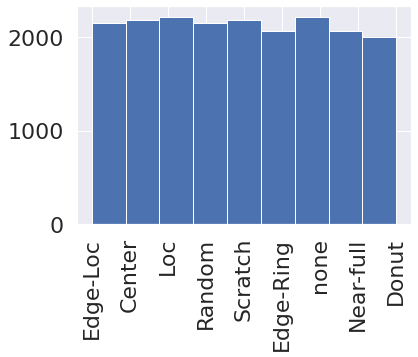

In [47]:
# the distribution of labels after undersampling
remove_wm = np.delete(resized_wm.detach().cpu().numpy(), delete_idx, axis=0)
resized_wm = torch.from_numpy(remove_wm)
del_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
label_wm = np.delete(label_wm, del_idx, axis=0)
n, bins, patches = plt.hist(label_wm, bins=9)
plt.xticks(rotation=90)
plt.show()

In [48]:
# One-hot-encoding for labels
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i    
    print('i : {}, l : {}'.format(i, l))
    
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)

label_wm = _to_one_hot(torch.as_tensor(np.int64(label_wm)), num_classes=9)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch
i : 8, l : none


In [49]:
# DataSet and DataLoader
from sklearn import model_selection

import torch.utils.data as data
class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)
    
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(resized_wm, label_wm , test_size=0.2)
dataset_train = BasicDataset(train_X,train_Y)
dataset_test = BasicDataset(test_X, test_Y)
dataset = ConcatDataset([dataset_train, dataset_test])

In [53]:
# Classification Model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob1 = 0.2
        self.keep_prob2 = 0.5

        self.layer1 =nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = nn.Linear(8 * 8 * 128, 1250, bias=True)
        # xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        
        self.layer4 = nn.Sequential(self.fc1,
                                    nn.ReLU())

        self.fc2 = nn.Linear(1250, 9, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out
    
CNN = CNN().to(DEVICE)
print(CNN)
summary(CNN,(3,56,56), batch_size=16)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=1250, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=8192, out_features=1250, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1250, out_features=9, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1  

In [54]:
args = {'BATCH_SIZE': 256,
        'LEARNING_RATE': 0.005,
        'NUM_EPOCH': 10}

In [55]:
# loss_func and optimizer
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(CNN.parameters(), lr=args['LEARNING_RATE'])
torch.manual_seed(42)
splits = KFold(n_splits=5, shuffle = True, random_state = 42)
foldperf={}

In [56]:
# Training and Validation Loop
def train_epoch(model, dataloader, loss_fn, optimizer):
    train_loss, train_correct= 0, 0
    model.train()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], 9)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
    print(train_correct)
    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'],9)
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [57]:
# K fold
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=train_sampler, drop_last=True)
    test_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=test_sampler, drop_last=True)
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(args['NUM_EPOCH']):
        train_loss, train_correct=train_epoch(CNN,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(CNN,test_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             args['NUM_EPOCH'],
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
    foldperf['fold{}'.format(fold+1)] = history  
torch.save(model,'k_cross_CNN.pt')     

Fold 1
9446
Epoch:1/10 AVG Training Loss:1.179 AVG Test Loss:0.394 AVG Training Acc 61.31 % AVG Test Acc 85.34 %
13882
Epoch:2/10 AVG Training Loss:0.274 AVG Test Loss:0.187 AVG Training Acc 90.10 % AVG Test Acc 93.51 %
14703
Epoch:3/10 AVG Training Loss:0.130 AVG Test Loss:0.138 AVG Training Acc 95.42 % AVG Test Acc 95.72 %
14914
Epoch:4/10 AVG Training Loss:0.089 AVG Test Loss:0.094 AVG Training Acc 96.79 % AVG Test Acc 96.39 %
15135
Epoch:5/10 AVG Training Loss:0.050 AVG Test Loss:0.059 AVG Training Acc 98.23 % AVG Test Acc 98.05 %
15172
Epoch:6/10 AVG Training Loss:0.038 AVG Test Loss:0.073 AVG Training Acc 98.47 % AVG Test Acc 97.74 %
15280
Epoch:7/10 AVG Training Loss:0.019 AVG Test Loss:0.051 AVG Training Acc 99.17 % AVG Test Acc 98.34 %
15277
Epoch:8/10 AVG Training Loss:0.018 AVG Test Loss:0.058 AVG Training Acc 99.15 % AVG Test Acc 98.29 %
15026
Epoch:9/10 AVG Training Loss:0.148 AVG Test Loss:0.154 AVG Training Acc 97.52 % AVG Test Acc 95.09 %
15137
Epoch:10/10 AVG Training 

In [58]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1, k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))       

Performance of 5 fold cross validation
Average Training Loss: 0.045 	 Average Test Loss: 0.032 	 Average Training Acc: 98.28 	 Average Test Acc: 98.70


In [59]:
tl_f

[0.19927813397645022,
 0.004650912973224716,
 0.008534055006270204,
 0.005437832181108949,
 0.00868402354542484]

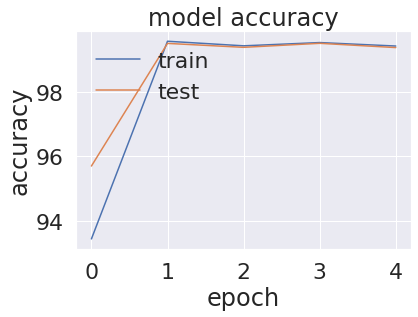

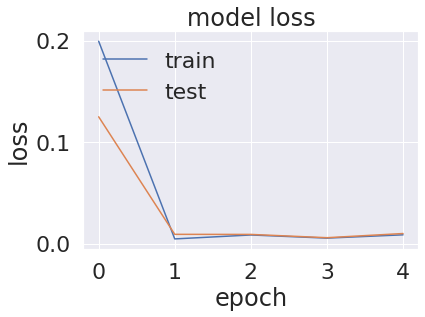

In [60]:
# accuracy plot
plt.plot(ta_f)
plt.plot(testa_f)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(tl_f)
plt.plot(testl_f)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()